Recurent version of "sinus-full" to predict values outside of range as well


In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from utils import shuffle_batch, variable_summaries
import os

%matplotlib notebook

dir_path = os.getcwd()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
print(dir_path)

C:\Users\kicjo\Desktop\my-anns\sinus_recurrent


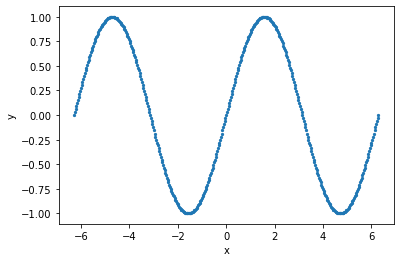

In [2]:
data_length = 401
noise = np.random.normal(0.01, 0.3, data_length)
x = np.linspace(-2 * np.pi, 2 * np.pi, data_length)
y = np.sin(x)  # + noise

plt.scatter(x, y, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()


In [3]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return np.sin(t)


def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

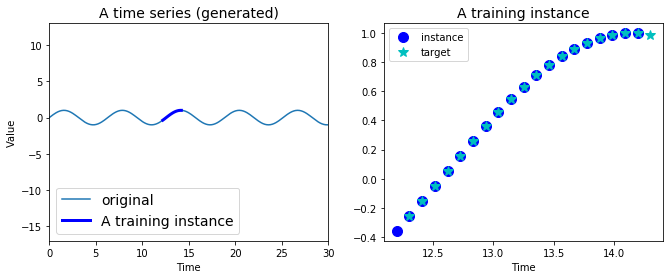

In [4]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"original")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "c*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [5]:
X_batch, y_batch = next_batch(1, n_steps)

In [6]:
n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])


In [7]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

W0801 15:58:10.674529 13952 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0801 15:58:10.675526 13952 deprecation.py:323] From <ipython-input-7-2161ecd35588>:2: BasicRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
W0801 15:58:10.678517 13952 deprecation.py:323] From <ipython-input-7-2161ecd35588>:5: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell

In [8]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [9]:
n_iterations = 1500
batch_size = 50
save_path =os.path.join(dir_path,"model","recurrent_sinus_model")

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, save_path)

0 	MSE: 0.51232034
100 	MSE: 0.007946246
200 	MSE: 0.0024722193
300 	MSE: 0.00088186533
400 	MSE: 0.000530849
500 	MSE: 0.0004463753
600 	MSE: 0.00048536982
700 	MSE: 0.0006329552
800 	MSE: 0.0006091202
900 	MSE: 0.00062315917
1000 	MSE: 0.00044484687
1100 	MSE: 0.00042196136
1200 	MSE: 0.00046205975
1300 	MSE: 0.0005308704
1400 	MSE: 0.00042046065


In [10]:
with tf.Session() as sess:                      
    saver.restore(sess, save_path)  

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

W0801 15:58:18.311311 13952 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


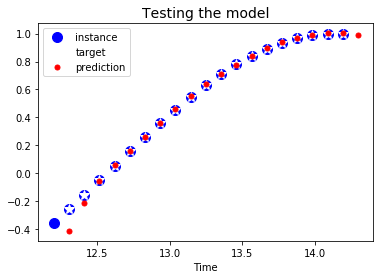

In [11]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [12]:
with tf.Session() as sess:                      
    saver.restore(sess, save_path)  

    X_new = time_series(np.array(t.reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

Text(0, 0.5, 'Value')

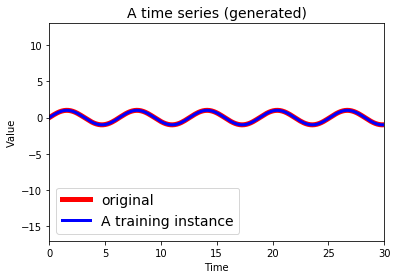

In [13]:
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"original",linewidth=5,c='r')
plt.plot(t[:-1], time_series(t[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")